In [214]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
import re
import json
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import regularizers
from keras.backend import mean
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Activation, Input, Dropout, \
    Add, add, LSTM, Bidirectional, Multiply, concatenate, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

%matplotlib inline

In [2]:
ls

HW4.pdf                     full-model-10.hdf5
Initial Exploration.ipynb   git_repo/
Preprocess and Train.ipynb  glove.6B/
data/                       train.py


In [3]:
ls data

train_annotations.json  train_questions.json    val_pairs.json
train_features.pickle   val_annotations.json    val_questions.json
train_pairs.json        val_features.pickle


In [4]:
ls glove.6B/

glove.6B.300d.txt


In [5]:
def load_json(json_file):
    json_data = open(json_file)
    data = json.load(json_data)
    json_data.close()
    return data

def load_pickle(pickle_file):
    pickle_data = open(pickle_file, "rb")
    data = pickle.load(pickle_data)
    pickle_data.close()
    return data

def load_glove(directory):
    glove = {}
    with open(directory) as file:
        for line in file:
            words = line.split(' ')
            word, vector = words[0], np.asarray(words[1:], dtype='float32')
            glove[word] = vector
    return glove

In [6]:
train_features = load_pickle("data/train_features.pickle")
val_features = load_pickle("data/val_features.pickle")
train_questions = load_json("data/train_questions.json")['questions']
val_questions = load_json("data/val_questions.json")['questions']
train_answers = load_json("data/train_annotations.json")['annotations']
val_answers = load_json("data/val_annotations.json")['annotations']

In [7]:
glove_dimension = 300
glove_directory = "glove.6B/glove.6B." + str(glove_dimension) + "d.txt"
glove = load_glove(glove_directory)

In [8]:
def extract_questions(questions, answers):
    data = {}
    for q in questions:
        data[q['question_id']] = {'q': q['question'], 'image_id': q['image_id']}
    for a in answers:
        data[a['question_id']]['a'] = a['multiple_choice_answer']
    return data

In [236]:
train_raw = extract_questions(train_questions, train_answers)
test_raw = extract_questions(val_questions, val_answers)

In [10]:
def top_answers(data, k=1000):
    answer_list = [v['a'] for k, v in data.items()]
    a_set = set(answer_list)
    w_to_i, i_to_w = {}, {}
    for i, w in enumerate(a_set):
        w_to_i[w] = i
        i_to_w[i] = w
    score = len(a_set) * [0]
    for w in answer_list: score[w_to_i[w]] += 1
    w_sorted = np.flip(np.argsort(score))
    top_a = [i_to_w[i] for i in w_sorted[:k]]
    proportion = np.sum([score[i] for i in w_sorted[:k]]) / len(answer_list)
    return top_a, proportion

In [11]:
answer_list, _ = top_answers(train_raw, k=2000)

In [12]:
def clean_sentence(s, glove):
    s_pre = s.lower().replace("\'s", " ").replace("\'", " ").replace("/", " ").replace("?", " ")
    s_clean = s_pre.replace("-", " ").replace(".", " ").replace(",", " ").replace("\"", " ")
    words = []
    for w in s_clean.split(" "):
        if w in glove: words.append(w)
    if len(words) == 0: return None
    return words

def minimize_vocab(train, test, glove):
    vocabulary = set()
    new_train, new_test = {}, {}
    for k, v in train.items():
        clean = clean_sentence(v['q'], glove)
        if clean == None: continue
        v['q'] = clean
        new_train[k] = v
        vocabulary.update(clean)
    for k, v in test.items():
        clean = clean_sentence(v['q'], glove)
        if clean == None: continue
        v['q'] = clean
        new_test[k] = v
        vocabulary.update(clean)
    return new_train, new_test, vocabulary

In [13]:
train_data, test_data, vocabulary = minimize_vocab(train_raw, test_raw, glove)

In [112]:
def a_to_one_hot(a, a_to_i, answer_length):
    b = np.zeros(answer_length)
    b[a_to_i[a]] = 1
    return b

def preprocessing(data, features, glove, answers, vocabulary):
    answer_length = len(answers)
    a_to_i = {w:i for i, w in enumerate(answers)}
    w_to_i = {w:(i+1) for i, w in enumerate(vocabulary)} 

    embedding = np.zeros(shape=(len(vocabulary) + 1, glove_dimension))
    for w, i in w_to_i.items():
        embedding[i,:] = glove[w]
        
    x_img, x_word, y = [], [], []
    for k, v in data.items():
        if v['a'] not in a_to_i: continue
        x_img.append(features[v['image_id']])
        x_word.append(np.array([w_to_i[w] for w in v['q']]))
        y.append(a_to_one_hot(v['a'], a_to_i, answer_length))
    x_word = sequence.pad_sequences(x_word, maxlen=25)
    x = [np.array(x_img), np.array(x_word)] # vstack(np.expand_dims(x_word, axis=0))
    return x, np.array(y), embedding, a_to_i

In [200]:
x_train, y_train, embedding, a_to_i = preprocessing(train_data, train_features, glove, answer_list, vocabulary)

In [114]:
def small_model(x, y, embedding, epochs=25):
    (vocab_size, vec_dim) = embedding.shape
    seq_length, output_dim = len(x[0]), len(y[0])
    model = Sequential()
    model.add(Embedding(vocab_size, vec_dim, weights=[embedding], input_length=seq_length, trainable=False))
    model.add(LSTM(512, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x, y, epochs=epochs, batch_size=64)
    return model

def medium_model(x, y, embedding, epochs=2):
    (vocab_size, vec_dim) = embedding.shape
    seq_length, output_dim = len(x[0]), len(y[0])
    model = Sequential()
    model.add(Embedding(vocab_size, vec_dim, weights=[embedding], input_length=seq_length, trainable=False))
    #model.add(Bidirectional(LSTM(512, return_sequences=True, activation='relu')))
    model.add(Bidirectional(LSTM(512, activation='relu')))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x, y, epochs=epochs, batch_size=64)
    return model

def full_model(x, y, embedding, epochs=100, hidden_dim=512):
    (vocab_size, vec_dim) = embedding.shape
    feat_dim, seq_length, output_dim = len(x[0][0]), len(x[1][0]), len(y[0])
    
    a1 = Input(shape=(feat_dim,))
    b1 = Dense(2*hidden_dim)(a1)

    a2 = Input(shape=(seq_length,))
    b2 = Embedding(vocab_size, vec_dim, weights=[embedding], input_length=seq_length, trainable=False)(a2)
    #b2 = Bidirectional(LSTM(hidden_dim, return_sequences=True, activation='relu'))(b2)
    b2 = Bidirectional(LSTM(hidden_dim, activation='relu'))(b2)
    
    #b = concatenate([b1, b2])
    b = Add()([b1, b2])
    c = Dense(output_dim, activation='softmax')(b)
    
    model = Model(inputs=[a1, a2], outputs=[c])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    checkpoint = ModelCheckpoint(filepath="full-model-{epoch:02d}.hdf5", period=10)
    model.fit(x, y, callbacks=[checkpoint], epochs=epochs, batch_size=64)
    return model

In [115]:
x_small, y_small = [x_train[0][:100], x_train[1][:100]], y_train[:100]

In [116]:
model = full_model(x_small, y_small, embedding, epochs=20)
#model = full_model(x_train, y_train, embedding, epochs=1)

Epoch 1/20
100/100 [==============================] - 8s 76ms/step - loss: 7.6415 - acc: 0.1400
Epoch 2/20
100/100 [==============================] - 1s 7ms/step - loss: 10.8814 - acc: 0.2000
Epoch 3/20
100/100 [==============================] - 1s 7ms/step - loss: 4.3762 - acc: 0.3200
Epoch 4/20
100/100 [==============================] - 1s 7ms/step - loss: 4.3555 - acc: 0.2800
Epoch 5/20
100/100 [==============================] - 1s 7ms/step - loss: 3.7521 - acc: 0.3300
Epoch 6/20
100/100 [==============================] - 1s 7ms/step - loss: 2.6644 - acc: 0.3400
Epoch 7/20
100/100 [==============================] - 1s 7ms/step - loss: 2.5491 - acc: 0.3600
Epoch 8/20
100/100 [==============================] - 1s 7ms/step - loss: 2.4783 - acc: 0.3800
Epoch 9/20
100/100 [==============================] - 1s 7ms/step - loss: 2.0522 - acc: 0.3900
Epoch 10/20
100/100 [==============================] - 1s 7ms/step - loss: 1.8944 - acc: 0.4600
Epoch 11/20
100/100 [==========================

In [117]:
def test_preprocess(data, features, glove, vocabulary):
    w_to_i = {w:i for i, w in enumerate(vocabulary)}     
    embedding = np.zeros(shape=(len(vocabulary), glove_dimension))
    for w, i in w_to_i.items(): embedding[i,:] = glove[w]
        
    x_img, x_word, y, q_id = [], [], [], []
    for k, v in data.items():
        x_img.append(features[v['image_id']])
        x_word.append(np.array([w_to_i[w] for w in v['q']]))
        y.append(v['a'])
        q_id.append(k) # k is question id!
    x_word = sequence.pad_sequences(x_word, maxlen=25)
    x = [np.array(x_img), np.array(x_word)]
    return x, y, q_id

In [118]:
x_test, y_test, q_test = test_preprocess(test_data, val_features, glove, vocabulary)

In [119]:
x_test_small, y_test_small, q_test_small = [x_test[0][:100], x_test[1][:100]], y_test[:100], q_test[:100]

In [120]:
def model_output(model, x_input, answer_key):
    y_index = model.predict(x_input)
    return [answer_key[np.argmax(pred)] for pred in y_index]

def evaluate(model, x_test, y_test, i_to_a):
    y_pred = model_output(model, x_test, i_to_a)
    score = np.mean([pred == truth for pred, truth in zip(y_pred, y_test)])
    return score

In [121]:
i_to_a = {i:a for a, i in a_to_i.items()}

In [122]:
y_pred = model_output(model, x_test_small, i_to_a)
score = evaluate(model, x_test_small, y_test_small, i_to_a)
print(score)

0.18


In [123]:
def write_results(results, file_name):
    with open(file_name, 'w') as f:
        for item in results:
            f.write("%s\n" % item)
            
def dict_to_json(preds, q_ids, file_name):
    d = [{'answer':p, 'question_id':i} for p, i in zip(preds, q_ids)]
    with open(file_name, 'w') as f:
        json.dump(d, f)

In [124]:
#write_results(y_pred, "small_preds.txt")
dict_to_json(y_pred, q_test[:100], 'small_pred.json')

In [125]:
ls git_repo/PythonEvaluationTools/

ls: git_repo/PythonEvaluationTools/: No such file or directory


In [126]:
ls models

add-model-05.hdf5     concat-model-10.hdf5  full_preds.txt
add-model-10.hdf5     concat-model-15.hdf5  small-model-01.hdf5
add-model-15.hdf5     full-model-01.hdf5    small_preds.txt
concat-model-05.hdf5  full-model-02.hdf5


In [127]:
add_15 = load_model("models/add-model-15.hdf5")

In [128]:
#score = evaluate(add_15, x_test, y_test, i_to_a)
#print(score)

KeyboardInterrupt: 

In [129]:
concat_10 = load_model("models/concat-model-10.hdf5")

In [130]:
score = evaluate(concat_10, x_test_small, y_test_small, i_to_a)
print(score)

0.21


In [131]:
concat_15 = load_model("models/concat-model-15.hdf5")

In [132]:
score = evaluate(concat_15, x_test_small, y_test_small, i_to_a)
print(score)

0.21


In [133]:
odd_pred = model_output(add_15, x_test_small, i_to_a)
print(odd_pred)

['yes', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'yes', 'parking meter', 'parking meter', 'parking meter', 'living room', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'yes', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking meter', 'parking me

In [134]:
def model_answer_json(model, x_input, q_ids, answer_key):
    y_index = model.predict(x_input)
    preds = [answer_key[np.argmax(pred)] for pred in y_index]
    d = [{'answer':p, 'question_id':i} for p, i in zip(preds, q_ids)]
    with open(file_name, 'w') as f:
        json.dump(d, f)

In [135]:
def ultimate_evaluate(file_name, model, x_test, y_test, q_ids, answer_key):
    y_index = model.predict(x_test)
    y_pred = [answer_key[np.argmax(pred)] for pred in y_index]
    score = np.mean([pred == truth for pred, truth in zip(y_pred, y_test)])
    d = [{'answer':p, 'question_id':i} for p, i in zip(y_pred, q_ids)]
    with open(file_name, 'w') as f:
        json.dump(d, f)
    return score

In [136]:
score = ultimate_evaluate("test.json", concat_15, x_test_small, y_test_small, q_test_small, i_to_a)

In [137]:
i_to_a[0]

'yes'

In [138]:
(vocab_size, vec_dim) = embedding.shape
feat_dim, seq_length, output_dim = len(x_train[0][0]), len(x_train[1][0]), len(y_train[0])

hidden_dim=512
a1 = Input(shape=(feat_dim,))
b1 = Dense(2 * hidden_dim, activation='relu')(a1)
b1 = Dropout(0.2)(b1)
b1 = Dense(2 * hidden_dim, activation='tanh', activity_regularizer=regularizers.l2(0.01))(b1)

a2 = Input(shape=(seq_length,))
b2 = Embedding(vocab_size, vec_dim, weights=[embedding], input_length=seq_length, trainable=False)(a2)
#b2 = LSTM(hidden_dim, activation='tanh', return_sequences=True)(b2)
b2 = LSTM(2 * hidden_dim, activation='tanh')(b2)

b = Multiply()([b1, b2])
c = Dense(2 * hidden_dim, activation='relu')(b)
c = Dropout(0.2)(c)
c = Dense(output_dim, activation='softmax')(b)

model = Model(inputs=[a1, a2], outputs=[c])
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()
model.fit(x_train, y_train, epochs=1, batch_size=64)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 1024)         2098176     input_45[0][0]                   
__________________________________________________________________________________________________
input_46 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, 1024)         0           dense_51[0][0]                   
__________________________________________________________________________________________________
embedding_

KeyboardInterrupt: 

In [ ]:
(vocab_size, vec_dim) = embedding.shape
feat_dim, seq_length, output_dim = len(x_train[0][0]), len(x_train[1][0]), len(y_train[0])

hidden_dim=512
a1 = Input(shape=(feat_dim,))
b1 = Dense(2 * hidden_dim, activation='relu')(a1)
b1 = Dropout(0.2)(b1)
b1 = Dense(2 * hidden_dim, activation='tanh', activity_regularizer=regularizers.l2(0.01))(b1)

a2 = Input(shape=(seq_length,))
b2 = Embedding(vocab_size, vec_dim, weights=[embedding], input_length=seq_length, trainable=False)(a2)
b2 = LSTM(hidden_dim, activation='tanh', return_sequences=True)(b2)
b2 = LSTM(2 * hidden_dim, activation='tanh')(b2)

b = Multiply()([b1, b2])
c = Dense(2 * hidden_dim, activation='relu')(b)
c = Dropout(0.2)(c)
c = Dense(output_dim, activation='softmax')(b)

model = Model(inputs=[a1, a2], outputs=[c])
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()
model.fit(x_train, y_train, epochs=1, batch_size=64)

In [141]:
a = np.argmax(y_train, axis=1)
a.shape

(404803,)

In [143]:
a[:10]

array([838, 381,  25,   0,   4,  39,   7,  18,   0,  18])

In [144]:
[i_to_a[v] for v in a[:10]]

['net',
 'pitcher',
 'orange',
 'yes',
 'white',
 'skiing',
 'red',
 'frisbee',
 'yes',
 'frisbee']

In [146]:
x_train[0][:10]

array([[0.06845431, 0.51872355, 0.57425696, ..., 0.09325539, 0.285767  ,
        0.03891068],
       [0.06845431, 0.51872355, 0.57425696, ..., 0.09325539, 0.285767  ,
        0.03891068],
       [0.06845431, 0.51872355, 0.57425696, ..., 0.09325539, 0.285767  ,
        0.03891068],
       ...,
       [0.52239937, 0.6562978 , 0.6981319 , ..., 0.5389304 , 0.28557733,
        1.4365244 ],
       [0.52239937, 0.6562978 , 0.6981319 , ..., 0.5389304 , 0.28557733,
        1.4365244 ],
       [0.52239937, 0.6562978 , 0.6981319 , ..., 0.5389304 , 0.28557733,
        1.4365244 ]], dtype=float32)

In [147]:
x_train[1][:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
         3464,  6128,  8956,  9965,  5765, 13076, 11436],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,  3464,  3892,  6128,  8956,  8086,   106],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,  3464, 13194,  6128, 10555,   398,  8616],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
         6128,  8956,  8086,  8299,  6771,  9083, 10929],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,  3464, 13194,  6128, 10555,  8824]],

In [150]:
final_model_1 = load_model("final-model-01.hdf5")

In [152]:
score = evaluate(final_model_1, [x_test[0][1000:2000], x_test[1][1000:2000]], y_test[1000:2000], i_to_a)
print(score)

0.187


In [153]:
def model_output(model, x_input, answer_key):
    y_index = model.predict(x_input)
    return [answer_key[np.argmax(pred)] for pred in y_index]

In [156]:
model_output(final_model_1, [x_test[0][1000:2000], x_test[1][1000:2000]], i_to_a)

['yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',


In [157]:
embedding[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [158]:
def small_model(x, y, embedding, epochs=25):
    (vocab_size, vec_dim) = embedding.shape
    seq_length, output_dim = len(x[0]), len(y[0])
    model = Sequential()
    model.add(Embedding(vocab_size, vec_dim, weights=[embedding], input_length=seq_length, trainable=False))
    model.add(LSTM(512, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x, y, epochs=epochs, batch_size=64)
    return model

In [160]:
m = small_model(x_test_small[1], y_test_small, embedding, epochs=1)

AttributeError: 'str' object has no attribute 'ndim'

In [166]:
index_test = np.argmax(np.array(y_train), axis=1)

In [173]:
np.mean([index_test == 1])

0.20384236282833873

In [175]:
i_to_a[1]

'no'

In [181]:
np.argmax(y_train[:100], axis=1)

array([ 838,  381,   25,    0,    4,   39,    7,   18,    0,   18,    0,
          0,    0,  306,    0,    1,    1,    1,    1,    1,    0,   42,
          1,    1,    0,   46,    2,    6,    1,   12,    0,   72,   15,
          3,    0,    1,  411,    0,   39,    2,    1,   39,   15,  128,
          1,    6,    0,  636,    1,   53,    0,    0,    0,   34,  341,
          1,  212,  398,    1,    0, 1932,   64,   64, 1117,    0,  241,
          8,    0,   86,    0,    1,    5,    0,   49,    0,  181,  118,
         54,    0,    0,    1,  118,    0,    1,    0,  987,    0,    0,
          1,    0,    3,    1,    3,   14,   12,   20,   45,    0,   28,
          1])

In [179]:
np.argmax(y_train[1])

381

In [201]:
def model_new_final(x, y, embedding, filepath, epochs=100, hidden_dim=512):
    (vocab_size, vec_dim) = embedding.shape
    feat_dim, seq_length, output_dim = len(x[0][0]), len(x[1][0]), len(y[0])

    a1 = Input(shape=(feat_dim,))
    b1 = Dense(hidden_dim, activation='tanh', activity_regularizer=regularizers.l2(0.01))(a1)

    a2 = Input(shape=(seq_length,))
    b2 = Embedding(vocab_size, vec_dim, weights=[embedding], input_length=seq_length, trainable=False)(a2)
    #b2 = LSTM(hidden_dim, activation='tanh', return_sequences=True)(b2)
    b2 = LSTM(hidden_dim, activation='tanh')(b2)

    b = Multiply()([b1, b2])
    c = Dense(hidden_dim, activation='relu')(b)
    c = Dropout(0.2)(c)
    c = Dense(output_dim, activation='softmax')(b)

    model = Model(inputs=[a1, a2], outputs=c)
    opt = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    checkpoint = ModelCheckpoint(filepath=filepath+"-{epoch:02d}.hdf5", period=1)
    model.fit(x, y, callbacks=[checkpoint], epochs=epochs, batch_size=64)
    return model

In [192]:
x_medium, y_medium = [x_train[0][:5000], x_train[1][:5000]], y_train[:5000]

In [197]:
another_model = model_new_final(x_medium, y_medium, embedding, "another_new", epochs=10)

Epoch 1/10
5000/5000 [==============================] - 49s 10ms/step - loss: 41.9796 - acc: 0.0578
Epoch 2/10
5000/5000 [==============================] - 41s 8ms/step - loss: 16.9020 - acc: 0.1126
Epoch 3/10
5000/5000 [==============================] - 48s 10ms/step - loss: 12.8846 - acc: 0.2524
Epoch 4/10
5000/5000 [==============================] - 41s 8ms/step - loss: 10.9003 - acc: 0.2442
Epoch 5/10
5000/5000 [==============================] - 40s 8ms/step - loss: 9.7535 - acc: 0.2460
Epoch 6/10
5000/5000 [==============================] - 42s 8ms/step - loss: 9.1619 - acc: 0.2404
Epoch 7/10
5000/5000 [==============================] - 42s 8ms/step - loss: 8.2796 - acc: 0.2470
Epoch 8/10
5000/5000 [==============================] - 44s 9ms/step - loss: 7.8129 - acc: 0.2580
Epoch 9/10
5000/5000 [==============================] - 44s 9ms/step - loss: 7.8373 - acc: 0.2594
Epoch 10/10
5000/5000 [==============================] - 42s 8ms/step - loss: 7.2350 - acc: 0.2610


In [203]:
def model_very_simple(x, y, embedding, filepath, epochs=100, hidden_dim=512):
    (vocab_size, vec_dim) = embedding.shape
    feat_dim, seq_length, output_dim = len(x[0][0]), len(x[1][0]), len(y[0])

    a1 = Input(shape=(feat_dim,))
    b1 = Dense(hidden_dim, activation='tanh', activity_regularizer=regularizers.l2(0.01))(a1)

    a2 = Input(shape=(seq_length,))
    b2 = Embedding(vocab_size, vec_dim, weights=[embedding], input_length=seq_length, trainable=False)(a2)
    b2 = LSTM(hidden_dim, activation='tanh')(b2)

    b = Multiply()([b1, b2])
    c = Dense(output_dim, activation='softmax')(b)

    model = Model(inputs=[a1, a2], outputs=c)
    opt = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    #checkpoint = ModelCheckpoint(filepath=filepath+"-{epoch:02d}.hdf5", period=1)
    model.fit(x, y, epochs=epochs, batch_size=64) # callbacks=[checkpoint]
    return model

In [204]:
super_simple_model = model_very_simple(x_medium, y_medium, embedding, "woah-simple", epochs=25)

Epoch 1/25
5000/5000 [==============================] - 28s 6ms/step - loss: 42.2133 - acc: 0.0280
Epoch 2/25
5000/5000 [==============================] - 18s 4ms/step - loss: 16.8863 - acc: 0.1378
Epoch 3/25
5000/5000 [==============================] - 19s 4ms/step - loss: 12.7951 - acc: 0.2420
Epoch 4/25
3456/5000 [===================>..........] - ETA: 5s - loss: 10.8773 - acc: 0.2468

KeyboardInterrupt: 

In [205]:
score = evaluate(another_model, [x_test[0][1000:2000], x_test[1][1000:2000]], y_test[1000:2000], i_to_a)
print(score)

0.19


In [206]:
so_simple = model_output(another_model, [x_test[0][1000:2000], x_test[1][1000:2000]], i_to_a)

In [208]:
so_simple[:10]

['no', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'yes']

In [220]:
def bow_model_1(x, y, embedding, epochs=10, hidden_dim=512):
    (vocab_size, vec_dim) = embedding.shape
    feat_dim, seq_length, output_dim = len(x[0][0]), len(x[1][0]), len(y[0])

    a1 = Input(shape=(feat_dim,))
    b1 = Dense(hidden_dim, activation='tanh')(a1)
    b1 = Dense(hidden_dim, activation='tanh')(b1)

    a2 = Input(shape=(seq_length,))
    b2 = Embedding(vocab_size, vec_dim, weights=[embedding], input_length=seq_length, trainable=False)(a2)
    b2 = Lambda(lambda x: mean(x, axis=1))(b2)
    b2 = Dense(hidden_dim, activation='tanh')(b2)
    b2 = Dense(hidden_dim, activation='tanh')(b2)

    b = Multiply()([b1, b2])
    c = Dense(output_dim, activation='softmax')(b)

    model = Model(inputs=[a1, a2], outputs=c)
    opt = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.fit(x, y, epochs=epochs, batch_size=64, verbose=2)
    return model

def bow_model_2(x, y, embedding, epochs=10, hidden_dim=512):
    (vocab_size, vec_dim) = embedding.shape
    feat_dim, seq_length, output_dim = len(x[0][0]), len(x[1][0]), len(y[0])

    a1 = Input(shape=(feat_dim,))
    b1 = Dense(hidden_dim, activation='tanh')(a1)

    a2 = Input(shape=(seq_length,))
    b2 = Embedding(vocab_size, vec_dim, weights=[embedding], input_length=seq_length, trainable=False)(a2)
    b2 = Lambda(lambda x: mean(x, axis=1))(b2)
    b2 = Dense(hidden_dim, activation='tanh')(b2)

    b = Multiply()([b1, b2])
    c = Dense(output_dim, activation='tanh')(b)
    c = Dense(output_dim, activation='tanh')(b)
    c = Dense(output_dim, activation='softmax')(b)

    model = Model(inputs=[a1, a2], outputs=c)
    opt = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.fit(x, y, epochs=epochs, batch_size=64, verbose=2)
    return model

In [221]:
m1 = bow_model_1(x_medium, y_medium, embedding)
m2 = bow_model_2(x_medium, y_medium, embedding)

Epoch 1/10
5000/5000 [==============================] - 11s 2ms/step - loss: 4.8100 - acc: 0.2062
Epoch 2/10
5000/5000 [==============================] - 2s 462us/step - loss: 3.5199 - acc: 0.2558
Epoch 3/10
5000/5000 [==============================] - 2s 449us/step - loss: 3.2399 - acc: 0.2686
Epoch 4/10
5000/5000 [==============================] - 2s 429us/step - loss: 3.0697 - acc: 0.2850
Epoch 5/10
5000/5000 [==============================] - 2s 432us/step - loss: 2.8955 - acc: 0.2978
Epoch 6/10
5000/5000 [==============================] - 2s 436us/step - loss: 2.7385 - acc: 0.3046
Epoch 7/10
5000/5000 [==============================] - 2s 441us/step - loss: 2.5889 - acc: 0.3188
Epoch 8/10
5000/5000 [==============================] - 2s 462us/step - loss: 2.4244 - acc: 0.3384
Epoch 9/10
5000/5000 [==============================] - 3s 511us/step - loss: 2.2762 - acc: 0.3434
Epoch 10/10
5000/5000 [==============================] - 3s 517us/step - loss: 2.1101 - acc: 0.3750
Epoch 1/10

In [222]:
m1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_66 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 25, 300)      4529100     input_66[0][0]                   
__________________________________________________________________________________________________
input_65 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 300)          0           embedding_33[0][0]               
__________________________________________________________________________________________________
dense_78 (

In [223]:
m2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_68 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_34 (Embedding)        (None, 25, 300)      4529100     input_68[0][0]                   
__________________________________________________________________________________________________
input_67 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 300)          0           embedding_34[0][0]               
__________________________________________________________________________________________________
dense_83 (

In [224]:
score = evaluate(m1, [x_test[0][1000:2000], x_test[1][1000:2000]], y_test[1000:2000], i_to_a)
print(score)

0.131


In [225]:
score = evaluate(m2, [x_test[0][1000:2000], x_test[1][1000:2000]], y_test[1000:2000], i_to_a)
print(score)

0.172


In [217]:
final_model = load_model("final-model-04.hdf5")

In [218]:
print(final_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 100)      1509700     input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          1049088     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

In [232]:
examples = np.random.choice(q_test, size=4)

In [238]:
for q_id in examples:
    print(q_id)
    print(test_raw[q_id])

574145003
{'q': 'How many pictures on the wall?', 'image_id': 574145, 'a': '2'}
202001006
{'q': 'Does the person have any facial piercings?', 'image_id': 202001, 'a': 'yes'}
42667003
{'q': 'What is the date at the bottom of the photo?', 'image_id': 42667, 'a': '2008/12/07'}
549907004
{'q': 'Is the elephant eating or drinking?', 'image_id': 549907, 'a': 'drinking'}


In [247]:
example_inputs = []
for i, idx in enumerate(q_test):
    if idx in examples:
        print(idx)
        example_inputs.append(i)

549907004
42667003
574145003
202001006


In [245]:
final_preds = model_output(final_model, [x_test[0][example_inputs], x_test[1][example_inputs]], i_to_a)

In [246]:
final_preds

['yes', 'police', 'orange', 'yes']

In [248]:
def load_test_imgs(data_dir, image_ids):
    imgs = {}
    dir_imgs = os.listdir(data_dir)
    for img_name in dir_imgs:
        id_num = int(img_name.split('_')[-1].split('.')[0])
        if id_num not in image_ids: continue
        img = plt.imread(data_dir + img_name)
        imgs[id_num] = img
    return imgs

In [254]:
image_list = []
for q_id in examples:
    image_list.append(test_raw[q_id]['image_id'])
test_images = load_test_imgs("data/val_images/", image_list)

549907


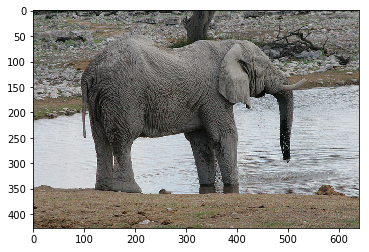

42667


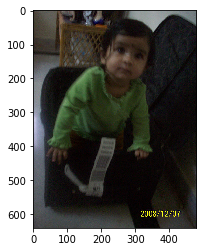

202001


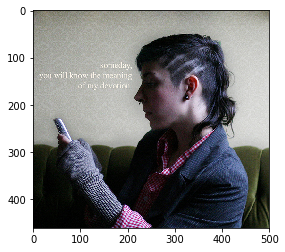

574145


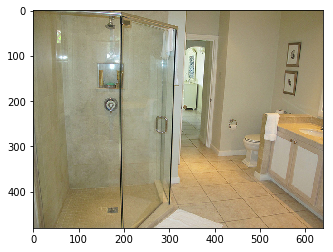

In [257]:
for k,v in test_images.items():
    print(k)
    plt.imshow(v)
    plt.show()

In [259]:
np.zeros(shape=(3,))

array([0., 0., 0.])